### **INITIALIZATION:**
- I use these three lines of code on top of my each notebooks because it will help to prevent any problems while reloading the same project. And the third line of code helps to make visualization within the notebook.


In [1]:
#@ INITIALIZATION:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**DOWNLOADING LIBRARIES AND DEPENDENCIES:**
- I have downloaded all the libraries and dependencies required for the project in one particular cell.

In [2]:
#@ DOWNLOADING THE LIBRARIES AND DEPENDENCIES:
# !pip install -U d2l
from d2l import torch as d2l

import os
import torch     
from torch import nn                                
from IPython import display

**GETTING THE DATASET:**
- I have used google colab for this project so the process of downloading and reading the data might be different in other platforms. I will use [**Large Movie Review Dataset**](https://ai.stanford.edu/~amaas/data/sentiment/) for this project. The dataset is divided into training and testing and each contains 25000 movie reviews. 

In [3]:
#@ GETTING THE DATASET: 
batch_size = 64                                                     # Initializing Batch Size. 
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)       # Initializing Training and Test Iterations. 

### **RECURRENT NEURAL NETWORK MODEL:**
- Each words obtains a feature vector from the embedding layer which is further encoded using bidirectional RNN to obtain sequence information. Here the `Embedding` instance is the embedding layer, the `LSTM` instance is the hidden layer for sequence encoding and the `Dense` instance is the output layer for generated classification result. 

In [4]:
#@ INITIALIZING RECURRENT NEURAL NETWORK MODEL: 
class BiRNN(nn.Module):                                                       # Initializing Bidirectional RNN. 
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, 
               **kwargs):                                                     # Initializing Constructor Function. 
    super(BiRNN, self).__init__(**kwargs)
    self.embedding = nn.Embedding(vocab_size, embed_size)                     # Initializing Embedding Layer. 
    self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers, 
                           bidirectional=True)                                # Initializing Bidirectional LSTM. 
    self.decoder = nn.Linear(4*num_hiddens, 2)                                # Initializing Linear Layer. 
  
  def forward(self, inputs):                                                  # Forward Propagation Function. 
    embeddings = self.embedding(inputs.T)                                     # Implementation of Embedding Layer. 
    self.encoder.flatten_parameters()    
    outputs, _ = self.encoder(embeddings)                                     # Implementation of LSTM. 
    encoding = torch.cat((outputs[0], outputs[-1]), dim=1)                    # Concatenating Initial and Final Timestep. 
    outs = self.decoder(encoding)                                             # Implementation of Linear Layer. 
    return outs

In [5]:
#@ IMPLEMENTATION OF RECURRENT NEURAL NETWORKS: 
embed_size, num_hiddens = 100, 100                              # Initialization of Parameters. 
num_layers, devices = 2, d2l.try_all_gpus()                     # Initialization of Parameters. 
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)    # Initialization of Bidirectional RNN Model. 

#@ INITIALIZATION OF WEIGHTS: 
def init_weights(m):                                            # Function for Initializing Weights. 
  if type(m) == nn.Linear:
    nn.init.xavier_uniform_(m.weight)                           # Xavier Initialization. 
  if type(m) == nn.LSTM:
    for param in m._flat_weights_names:
      if "weight" in param:
        nn.init.xavier_uniform_(m._parameters[param])           # Xavier Initialization. 
net.apply(init_weights);                                        # Initializing Weights. 

**PRETRAINED WORD VECTORS:**
- Inorder to prevent overfitting, I will directly use word vectors pretrained on a larger corpus as the feature vectors of all words. 

In [6]:
#@ LOADING PRETRAINED WORD VECTORS: 
glove_embedding = d2l.TokenEmbedding("glove.6b.100d")              # Initializing 100D Glove Word Vector. 
embeds = glove_embedding[vocab.idx_to_token]                       # Word Vectors in Vocabulary. 
net.embedding.weight.data.copy_(embeds)                            # Using Word Vectors as Features. 
net.embedding.weight.requires_grad = False                         

**TRAINING AND EVALUATING MODEL:**

loss 0.280, train acc 0.881, test acc 0.860
998.4 examples/sec on [device(type='cuda', index=0)]


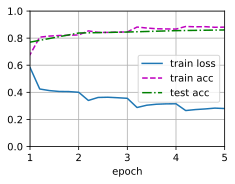

In [7]:
#@ TRAINING THE MODEL: 
lr, num_epochs = 0.01, 5                                           # Initializing Parameters. 
trainer = torch.optim.Adam(net.parameters(), lr=lr)                # Initializing Adam Optimizer. 
loss = nn.CrossEntropyLoss(reduction="none")                       # Initializing Cross Entropy Loss Function. 
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, 
               num_epochs, devices)                                # Training the Model. 

In [11]:
#@ MODEL EVALUATION:
def predict_sentiment(net, vocab, sentence):                                # Defining Prediction Function. 
  sentence = torch.tensor(vocab[sentence.split()], device=d2l.try_gpu())
  label = torch.argmax(net(sentence.reshape(1, -1)), dim=1)
  return "positive" if label == 1 else "negative"
#@ IMPLEMENTATION: 
predict_sentiment(net, vocab, "the movie was boring")                       # Model Evaluation. 

'negative'